In [69]:
import numpy as np
import matplotlib.pyplot as plt
from synthesizer.photoionisation import cloudy23 as cloudy
from synthesizer import line_ratios
from synthesizer.sed import Sed
from astropy.io import ascii
from unyt import erg, s, Hz, cm, Angstrom, Ry, c

In [70]:

model = 'nlr_default'
model = 'blr_default'
# model = 'blr_ionisation_parameter:-2.0'
# model = 'blr_ionisation_parameter:0.0'
# model = 'blr_no-xrays'
# model = 'blr_50ev-cut'
# model = 'cloudy_blr_model'

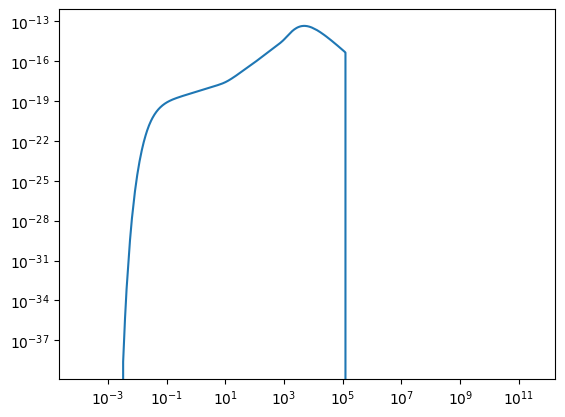

In [71]:
line_ids, blends, wavelengths, intrinsic, emergent = cloudy.read_lines(f'{model}/1')


linelist_type = 'intrinsic'

linelist = cloudy.read_linelist(f'{model}/1', extension=f'{linelist_type}_elin')

# convert tuple of arrays into a dictionary
line_luminosity = dict(zip(linelist[0], linelist[2] * erg/s))

# read spectra
# lam, nu, incident, transmitted, nebular, nebular_continuum, total, linecont, = cloudy.read_continuum(f'{model}/1')


x, incident, transmitted, nebular, total, linecont = np.loadtxt(f"{model}/1.cont", delimiter="\t", usecols=(0, 1, 2, 3, 4, 8)).T

# x appears to be frequency even though we've instisted it be Angstrom?!

lam = x[::-1] * Angstrom
nu = c / lam
lnu = incident[::-1] * (erg / s)  / nu / 1E7

plt.loglog(lam.to('Angstrom').value, lnu)
plt.show()


In [72]:
# Case B correction factor
correction_factor = (1.08E-53 / 7.9E-42) * erg

print(f"H-alpha luminosity: {np.log10(line_luminosity['H 1 6562.80A']):.2f}")

print(f"Balmer decrement: {line_luminosity['H 1 6562.80A']/line_luminosity['H 1 4861.32A']:.2f}")

sed = Sed(lam=lam, lnu=lnu)

print(f"H-alpha bolometric correction: {sed.bolometric_luminosity/line_luminosity['H 1 6562.80A']:.2f}")

Q = sed.calculate_ionising_photon_production_rate()

print(f"ionising photo luminosity: {np.log10(Q):.2f}")

print(f"L_Halpha/Q: {np.log10(line_luminosity['H 1 6562.80A']/Q):.2f} ({np.log10(correction_factor):.2f})")

H-alpha luminosity: 0.54
Balmer decrement: 6.09 dimensionless
H-alpha bolometric correction: 24.84 dimensionless
ionising photo luminosity: 11.48
L_Halpha/Q: -10.93 (-11.86)


### Plot BPT

3.2918898788208666e-05 dimensionless 0.0007364737503490644 dimensionless


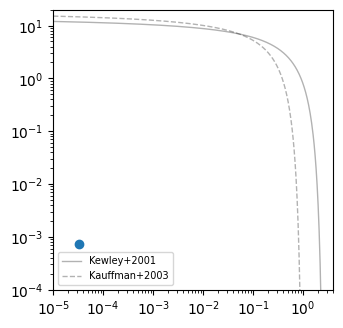

In [73]:
fig = plt.figure(figsize=(3.5, 3.5))

bottom = 0.15
height = 0.8
left = 0.15
width = 0.8

ax = fig.add_axes((left, bottom, width, height))

# plot Kewley and Kauffmann lines 
for f, ls, limit, label in zip(
        [line_ratios.get_bpt_kewley01, line_ratios.get_bpt_kauffman03],
        ['-', '--'],
        [0.47, 0.05],
        ['Kewley+2001', 'Kauffman+2003']):
    log10x = np.arange(-5., limit, 0.01)
    ax.plot(10**log10x, 10**f(log10x), ls=ls, lw=1, c='k', alpha=0.3, label=label)


x = line_luminosity['N 2 6583.45A']/line_luminosity['H 1 6562.80A']
y = line_luminosity['O 3 5006.84A']/line_luminosity['H 1 4861.32A']

print(x,y)

ax.scatter(x,y)

ax.legend(fontsize=7, loc='lower left')
ax.set_xlim([0.00001, 4])
ax.set_ylim([0.0001, 20])
ax.set_xscale('log')
ax.set_yscale('log')

plt.show()


### Plot ionisation structure of the cloud

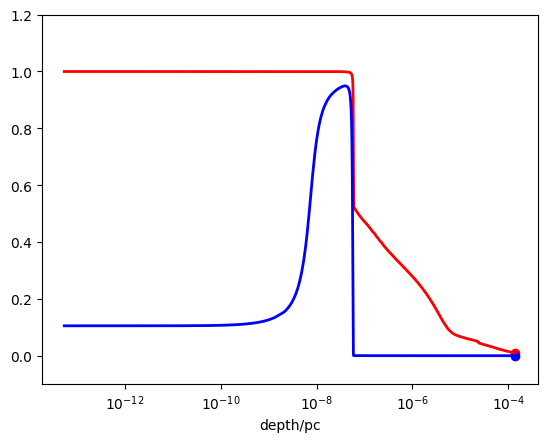

In [74]:
from unyt import cm, pc

convert_to_parsecs = (1*cm).to('pc').value

for zone, c in zip(['HII', 'O3'],['r', 'b']):
    data = ascii.read(f'{model}/{1}.ovr')
    data['depth'] *= convert_to_parsecs
    plt.plot(data['depth'], data[zone], lw=2, c=c)
    plt.scatter(data['depth'][-1], data[zone][-1], c=c)

plt.xscale('log')
plt.ylim(-0.1, 1.2)
plt.xlabel('depth/pc')
plt.show()

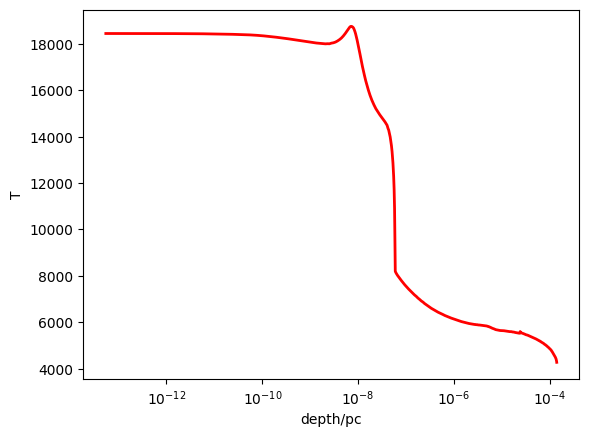

In [75]:
from unyt import cm, pc

convert_to_parsecs = (1*cm).to('pc').value


data = ascii.read(f'{model}/{1}.ovr')
data['depth'] *= convert_to_parsecs
plt.plot(data['depth'], data['Te'], lw=2, c='r')

plt.xscale('log')
# plt.ylim(-0.1, 1.2)
plt.xlabel('depth/pc')
plt.ylabel('T')
plt.show()

### Plot spectra

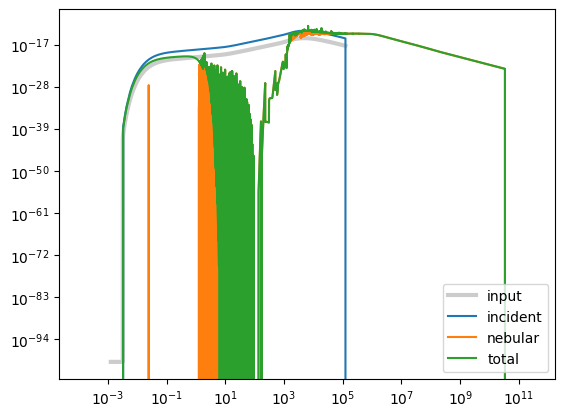

In [76]:

# get the input spectra
from unyt import c, h

input_E, input_lnu = np.loadtxt(f'{model}/1.sed').T
input_E *= Ry
input_nu = input_E / h
input_lam = c / input_nu
input_lnu *= erg/s/Hz


plt.loglog(input_lam.to('Angstrom').value, input_lnu.to('erg/s/Hz').value, c='k', lw=3, alpha=0.2, label="input")

# get the output spectra
x, incident, transmitted, nebular, total, linecont = np.loadtxt(f"{model}/1.cont", delimiter="\t", usecols=(0, 1, 2, 3, 4, 8)).T

lam = x[::-1] * Angstrom
nu = c / lam

for spectra, label in zip([incident, nebular, total], ['incident', 'nebular', 'total']):
    spectra = spectra[::-1] * (erg / s)  / nu / 1E7
    plt.loglog(lam.to('Angstrom').value, spectra, label=label)

plt.legend()
plt.show()



